In [1]:
import matplotlib.pyplot as plt
import src.util_fns as util_fns
import pickle
import numpy as np
import cv2
import os
from pathlib import Path
import xml.etree.ElementTree as ET
import sklearn.metrics
import torchvision
import torch

In [2]:
metadata = pickle.load(open('./data/metadata.pkl', 'rb'))

raw_data_path = '/userdata/kerasData/data/new_data/raw_images_inference/'
raw_labels_path = '/userdata/kerasData/data/new_data/drive_clone/'
labels_path = '/root/pytorch_lightning_data/drive_clone_numpy/'

example = labels_path+'20180504_FIRE_smer-tcs8-mobo-c/xml/1525469995_+00360.xml'

# Hard Example Mining

In [3]:
def create_hem_list(image_preds_path, output_path):
    """Description: Creates txt file of hardest positive and negative examples sorted by image_loss"""
    
    csv = np.loadtxt(image_preds_path, delimiter=',', dtype=str)

    positive_images = {}
    negative_images = {}

    for image, pred, loss in csv:
        if util_fns.get_ground_truth_label(image) == 1:
            positive_images[image] = float(loss)
        else:
            negative_images[image] = float(loss)

    num_to_keep = (len(positive_images)+len(negative_images))//10

    hem_list = sorted(negative_images, key=negative_images.get)[-num_to_keep:] + sorted(positive_images, key=positive_images.get)[-num_to_keep:]

    np.savetxt(output_path, hem_list, fmt='%s')
    

In [6]:
image_preds_path = './saved_logs/versions_246-258/version_246_hem-test/image_preds.csv'
output_path = './data/final_split/hem-train_images_final.txt'

create_hem_list(image_preds_path, output_path)

# Helper Functions

In [8]:
def calculate_overlap_ticks(max_dim, tile_size=224, tile_overlap=20):
    i = 0
    dim = 0
    ticks = []

    while dim < max_dim:
        if i == 0:
            dim += tile_size-tile_overlap
        elif i % 2 == 1:
            dim += tile_overlap
        elif i % 2 == 0:
            dim += tile_size-tile_overlap*2

        ticks.append(dim)
        i += 1
    
    return ticks

In [12]:
def display_image(image_name, 
                  image_pred=None, 
                  image_prob=None,
                  tile_preds=None, 
                  tile_probs=None, 
                  idx=0, 
                  save_path=None, 
                  resize_dimensions = (1392, 1856),
                  crop_height = 1040,
                  tile_dimensions = (224, 224),
                  tile_overlap = 20,
                  grid=True):
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    image_path = raw_data_path+image_name+'.jpg'
    label_image_path = raw_labels_path+util_fns.get_fire_name(image_name)+'/labels/'+util_fns.get_only_image_name(image_name)+'.jpg'
    
    gt_label = util_fns.get_ground_truth_label(image_name)
    
    if Path(label_image_path).exists():
        filename = label_image_path
    elif Path(image_path).exists():
        filename = image_path
    else:
        print('No image to display.')
        return
    
    # Load and process image
    img = cv2.imread(filename)
    img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display image
    plt.figure(figsize=(16, 12), dpi=80)
    
    plt.title('ID: ' + str(idx), loc='left')
    plt.title(image_name, loc='center', color='black' if gt_label==0 else 'red')
    if image_pred is not None:
        is_correct = image_pred == gt_label
        plt.title('IMAGE_PROB={}, IMAGE_PRED={}'.format(image_prob, image_pred) + ' , loc='right', color='black' if is_correct else 'red')
    
    plt.imshow(img)
    
    # Calculate grid ticks
    if grid:
        plt.xticks(calculate_overlap_ticks(resize_dimensions[1], tile_dimensions[1], tile_overlap), alpha=0)
        plt.yticks(calculate_overlap_ticks(crop_height, tile_dimensions[0], tile_overlap), alpha=0)
        plt.grid()
    else:
        plt.xticks([])
        plt.yticks([])
    
    # Insert tile preds text
    if tile_preds is not None or tile_probs is not None:
        x_text_ticks = np.insert(np.arange(tile_dimensions[1],resize_dimensions[1],tile_dimensions[1]-tile_overlap), 0, 0)
        y_text_ticks = np.insert(np.arange(tile_dimensions[0],crop_height,tile_dimensions[0]-tile_overlap), 0, 0)+tile_overlap

        for i, x in enumerate(x_text_ticks):
            for j, y in enumerate(y_text_ticks):
                if tile_preds is not None:
                    plt.text(x,y, tile_preds[j,i], size='medium', weight='heavy', color='white' if tile_preds[j,i]==0 else 'red')
                else:
                    plt.text(x,y, round(tile_probs[j,i], 2), size='medium', weight='heavy', color='white' if tile_probs[j,i]<0.5 else 'red')
                    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()

In [13]:
def display_raw_labels(filename):
    """
    View multiple images stored in files, stacking vertically

    Arguments:
        filename: str - path to filename containing image
    """
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
    
    plt.figure(figsize=(16, 12), dpi=80)
    plt.title(filename)
    plt.imshow(img)

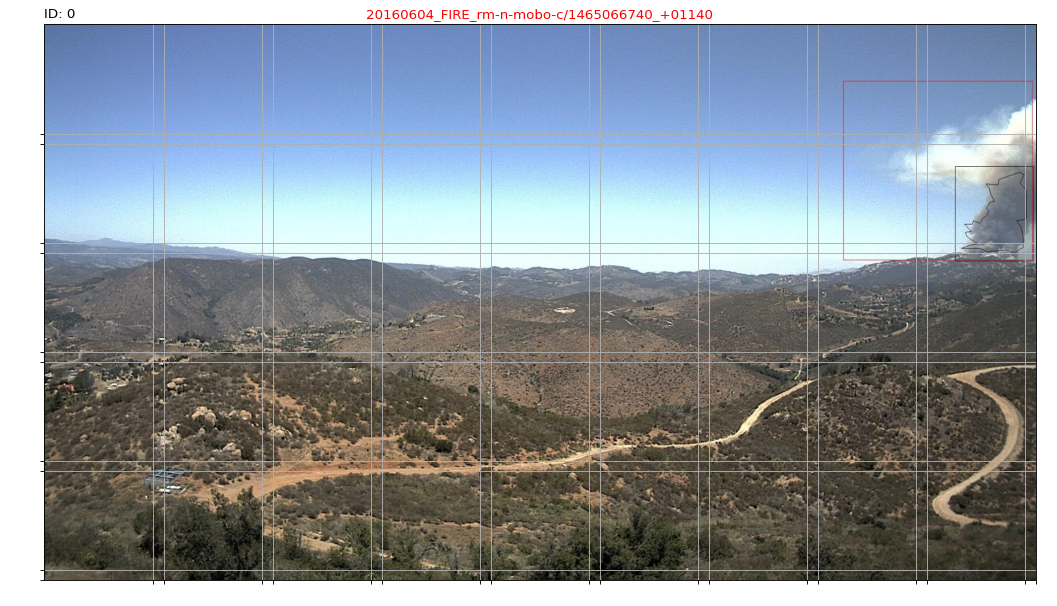

In [7]:
display_image('20160604_FIRE_rm-n-mobo-c/1465066740_+01140')

# Visualize Errors

In [14]:
save_path = None

# EDIT: dimensions
resize_dimensions = (1392, 1856)
crop_height = 1040
tile_dimensions = (224, 224)
tile_overlap = 20
num_tiles_height, num_tiles_width = util_fns.calculate_num_tiles(resize_dimensions, crop_height, tile_dimensions, tile_overlap)

# EDIT: path to results
results_path = '/userdata/kerasData/src/pytorch-lightning-smoke-detection/lightning_logs/Final_ResNet34_LSTM_SpatialViT_Inference/version_0/'

# EDIT: If fig should be saved
save_path = './saved_figs/inference/'
os.makedirs(save_path, exist_ok=True)

image_preds = np.loadtxt(results_path+'image_preds.csv', delimiter=',', dtype=str)
for j, (image, image_pred, image_prob, loss) in enumerate(image_preds):
    # EDIT: Change j < <value> to search for next error
    if j < 0: continue
    
    ### Errors Only ###
#     if int(image_pred) == util_fns.get_ground_truth_label(image): continue
    ### False Positives Only ###
#     if int(image_pred) != 1 or util_fns.get_ground_truth_label(image) != 0: continue
    ### False Negatives Only ###
#     if int(image_pred) != 0 or util_fns.get_ground_truth_label(image) != 1: continue
    ### Correct Only ###
#     if int(image_pred) != util_fns.get_ground_truth_label(image): continue
    ### True Positives Only ###
#     if int(image_pred) != 1 or util_fns.get_ground_truth_label(image) != 1: continue
    ### True Negatives Only ###
#     if int(image_pred) != 0 or util_fns.get_ground_truth_label(image) != 0: continue
        
    # Save path variables
    tile_probs_path = results_path+'tile_probs/'+image+'.npy'
    tile_preds_path = results_path+'tile_preds/'+image+'.npy'
    save_path_j = save_path+str(j) if save_path is not None else None
    
    ### Tile Prediction != Image Prediction ###
#      preds = np.load(tile_preds_path).reshape((num_tiles_height,num_tiles_width))
#     if (preds.sum() > 0 and int(image_pred) == 1) or (preds.sum() == 0 and int(image_pred) == 0): continue
    
    # Load preds
    probs = np.load(tile_probs_path).reshape((num_tiles_height,num_tiles_width))
    
    # Display image
    display_image(image, int(image_pred), int(image_prob), tile_probs=probs, idx=j, save_path=save_path_j)
        
    if save_path is None: break

# Display Bounding Boxes

In [26]:
def display_bounding_box(image_name, resize_dimensions = (1392, 1856), crop_height = 1040):
    label_image_path = raw_data_path+image_name+'.jpg'
    img = cv2.imread(label_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    resize_factor = np.array(resize_dimensions) / np.array(img.shape[:2])

    img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
    img = img.transpose(2,0,1)

    bboxes = []
    gt_bboxes = metadata['bbox_labels'][image_name]
    for i in range(len(gt_bboxes)):
        bboxes.append([0,0,0,0])
        bboxes[i][0] = gt_bboxes[i][0]*resize_factor[1]
        bboxes[i][1] = gt_bboxes[i][1]*resize_factor[0] - (resize_dimensions[0]-crop_height)
        bboxes[i][2] = gt_bboxes[i][2]*resize_factor[1]
        bboxes[i][3] = gt_bboxes[i][3]*resize_factor[0] - (resize_dimensions[0]-crop_height)
    
        bboxes[i][1] = np.maximum(bboxes[i][1], 0)
        bboxes[i][3] = np.maximum(bboxes[i][3], 1)
    
    imgs = torchvision.utils.draw_bounding_boxes(torch.as_tensor(img, dtype=torch.uint8), torch.as_tensor(bboxes))
    
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(16, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

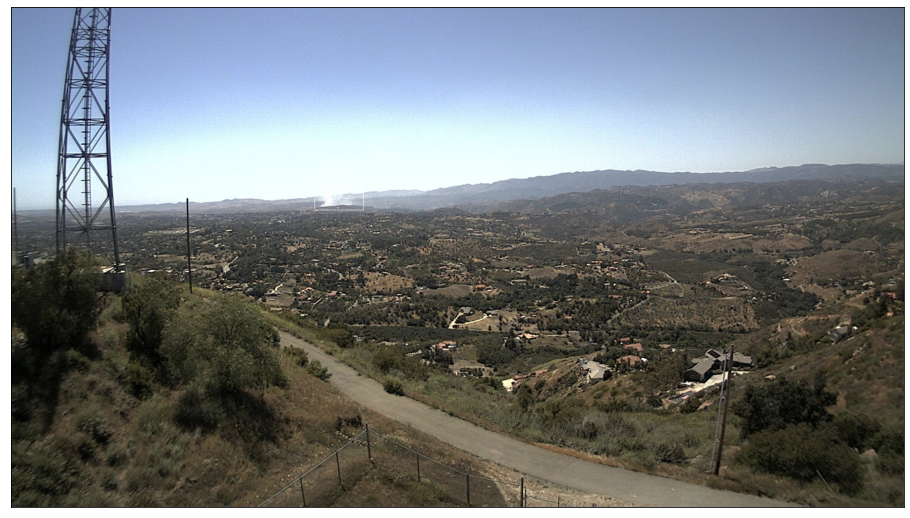

In [27]:
display_bounding_box('20170519_FIRE_rm-w-mobo-c/1495228626_+02340')

# Human Experiment

In [13]:
def generate_human_experiment(num_images=50, 
                              series_length=2, 
                              save_path='./human_experiment/trial0_num50_series2/', 
                              resize_dimensions = (1392, 1856), 
                              crop_height = 1040):
    
    os.makedirs(save_path, exist_ok=True)
    os.makedirs(save_path+'ANSWER_KEY/', exist_ok=True)
    os.makedirs(save_path+'INPUT_ANSWERS/', exist_ok=True)
    
#     eligible_fires = []

#     for fire in metadata['fire_to_images']:
#         if fire not in metadata['night_fires'] and len(metadata['fire_to_images'][fire]) > series_length:
#             eligible_fires.append(fire)

    images = np.loadtxt('./data/final_split/test_images_final.txt', dtype=str)
    eligible_fires = set([])
    for image in images:
        eligible_fires.add(util_fns.get_fire_name(image))
    eligible_fires = list(eligible_fires)

    selected_fires = np.random.choice(eligible_fires, num_images, replace=False)

    selected_indices = []
    selected_images = []

    for fire in selected_fires:
        selected_index = np.random.randint(series_length-1,len(metadata['fire_to_images'][fire]))
        selected_image = metadata['fire_to_images'][fire][selected_index]

        selected_indices.append(selected_index)
        selected_images.append(selected_image)
        
    for i in range(num_images):
        current_fire = selected_fires[i]
        
        for j in range(series_length):
            current_index = selected_indices[i] - series_length + j + 1
            
            image_name = metadata['fire_to_images'][current_fire][current_index]
            
            image_path = raw_data_path+image_name+'.jpg'
            
            # Load and process image
            img = cv2.imread(image_path)
            img = cv2.resize(img, (resize_dimensions[1],resize_dimensions[0]))[-crop_height:]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Display image
            plt.figure(figsize=(16, 12), dpi=80)

            title = 'ID-'+('0' if i < 10 else '')+str(i)+'_FRAME-'+str(j)
            title += '_PREDICT' if j == series_length-1 else ''
            plt.title(title)
            plt.xticks([])
            plt.yticks([])

            plt.imshow(img)

            plt.savefig(save_path+title+'.jpg', bbox_inches='tight')
            plt.close()
            
    answer_key = []
    for i, image in enumerate(selected_images):
        answer_key.append([image, i, util_fns.get_ground_truth_label(image)])
    
    np.savetxt(save_path+'ANSWER_KEY/answer_key.csv', answer_key, delimiter=',', fmt='%s')
    
    

In [14]:
generate_human_experiment(num_images=50, series_length=4, save_path='./human_experiment/trial2_num50_series4/')



In [3]:
def score_human_experiment(input_answers_path, answer_key_path):
    input_answers = np.loadtxt(input_answers_path, delimiter=',', dtype=str)
    answer_key = np.loadtxt(answer_key_path, delimiter=',', dtype=str)
        
    answers = []
    preds = []
    errors = []
    for i in range(len(answer_key)):
        answer = int(answer_key[i][2])
        pred = int(input_answers[i][1])
        
        if util_fns.get_fire_name(answer_key[i][0]) in metadata['mislabeled_fires']:
            print(util_fns.get_fire_name(answer_key[i][0]))
            continue
        
        answers.append(answer)
        preds.append(pred)
        
        if answer != pred:
            errors.append(answer_key[i][0])
        
    return sklearn.metrics.accuracy_score(answers, preds), errors

In [9]:
score_human_experiment('./human_experiment/trial1_num50_series2/INPUT_ANSWERS/input_answers_duolan.txt', './human_experiment/trial1_num50_series2/ANSWER_KEY/answer_key.csv')


20200608_FIRE_rm-w-mobo-c
20190715_MLOSouth2_lo-s-mobo-c
20191006_FIRE_om-s-mobo-c
20190716_FIRE_bl-s-mobo-c
20200813_Ranch2Fire_wilson-e-mobo-c
20201208_FIRE_om-s-mobo-c


(0.8636363636363636,
 ['20200828_BorderFire_sm-s-mobo-c/1598629231_+00060',
  '20200705_FIRE_bm-w-mobo-c/1593984939_+01680',
  '20200806_BorderFire_lp-s-mobo-c/1596730385_+01020',
  '20200822_SloaneFire_lp-w-mobo-c/1598132227_+02340',
  '20200601_WILDLAND-DRILLS_om-e-mobo-c/1591046137_+01380',
  '20190826_FIRE_rm-w-mobo-c/1566851226_+02337'])

In [10]:
x = np.array([0.8863636363636364, 0.8181818181818182, 0.8636363636363636])

print(x.mean())
print(x.std())

0.8560606060606061
0.028345889293741953
